<a href="https://colab.research.google.com/github/abdu355/simCLR-ml701/blob/main/ml701_Proj_Midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SimCLR Feature Extractor + OCT CLassifier ( Pytorch Lightning )

List of full videos is here:    

https://www.youtube.com/playlist?list=PLaMu-SDt_RB4k8VXiB3hOdsn0Y3GoXo1k

Pretrained simCLR2: https://console.cloud.google.com/storage/browser/simclr-checkpoints/simclrv2/pretrained?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false

In [ ]:
%%capture
# ! pip install pytorch-lightning-bolts
# ! pip install pytorch-lightning
# ! pip install image
# ! pip install lightning-flash
# ! pip install comet-ml
# ! pip install captum
# ! pip install Pillow

# use requirements.txt provided on WA
! pip install -r requirements.txt
# restart kernel once done 

In [ ]:
# pip freeze > requirements.txt

## Importing libraries and Dataset

In [63]:
# comet
from comet_ml import Experiment
from pytorch_lightning.loggers import CometLogger

# ----- general import -----
import torch
import pytorch_lightning as pl
import zipfile
import os
import pandas as pd
import numpy as np
import torch
import torchvision
from datetime import datetime

# ----- dataloader imports -----
from flash import download_data
from  pl_bolts.datamodules.async_dataloader import AsynchronousLoader
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# ----- datamodule imports -----
from torch.utils.data import random_split
# from torch.utils.data import RandomSampler
import matplotlib.pyplot as plt
import math

# ----- data transforms imports -----
import torchvision.transforms as transforms
import torchvision.transforms.functional as tvf

# ----- model imports -----
from pl_bolts.models.self_supervised import SimCLR
from pytorch_lightning.callbacks import Callback
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from pl_bolts.models import LinearRegression, LogisticRegression
import torchvision.models as models
from argparse import Namespace
from pytorch_lightning.callbacks import LearningRateMonitor

# ----- evaluation imports -----
from sklearn.metrics import classification_report

# ----- check kernel device -----
# if you get CPU, change Runtime type to GPU. Top menu: Runtime > Change Runtime type > GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
#load data with Flash - $$$ keep in mind this action incurs a cost on AWS $$$
download_data("https://ml701.s3.me-south-1.amazonaws.com/OCT2017_M.zip", "data/")

In [ ]:
#class map
idx_to_label = {
    0: 'NORMAL',
    1: 'CNV',
    2: 'DME',
    3: 'DRUSEN'
}

#fix state for data seed
random_state = 6

num_of_classes = int(len(idx_to_label))
frac_train_images = .6 # update 
batch_size = 32 # update
optimizer = 'Adagrad' # update

#download data from step above before setting root_dir
root_dir = 'data/OCT2017_M'

#explore dataset
total_train = pd.read_csv(f"{root_dir}/train.csv")
data = total_train.sample(frac=frac_train_images, random_state=random_state)
print(f"total train data size: {total_train.shape}, sample train data size: {data.shape}")
data.head()

total train data size: (5200, 2), sample train data size: (3120, 2)


,image_id,label
134,CNV-103044-37.jpeg,1
521,CNV-154835-89.jpeg,1
614,CNV-163081-172.jpeg,1
4523,NORMAL-285896-14.jpeg,0
3417,DRUSEN-525301-3.jpeg,3


### Defining Dataloader and Transformer

In [ ]:
#dataset
class OCTDataset(Dataset):
    """ OCT Dataset """
    def __init__(self, root_dir, frac_train_images=1, transform=None, stage=False, random_state=1):
        if stage: 
            csv_output = pd.read_csv(os.path.join(root_dir, "test.csv"))
            self.images_dir = os.path.join(root_dir, "test")
        else:
            total_csv_output = pd.read_csv(os.path.join(root_dir, "train.csv"))
            csv_output = total_csv_output.sample(frac=frac_train_images, 
                                                 random_state=random_state)
            self.images_dir = os.path.join(root_dir, "train")

        self.image_urls = np.asarray(csv_output["image_id"])
        self.labels = np.asarray(csv_output["label"])
        self.transform = transform
        
    def __len__(self):
        return len(self.image_urls)
    
    def __getitem__(self, idx):
        # Get and load image
        image_path = os.path.join(self.images_dir, self.image_urls[idx])
        image = Image.open(image_path)
        # Perform transforms if any
        if self.transform:
            image = self.transform(image)
        # Get label
        label = self.labels[idx]   
        return image, label

In [ ]:
#datamodule
class OCTDataModule(pl.LightningDataModule):
    """ OCT DataModule for Lightning """
    def __init__(self, root_dir, frac_train_images=1, transform=None, batch_size=32, random_state=1):
        super().__init__()
        self.batch_size = batch_size
        self.root_dir = root_dir
        self.transform = transform
        self.frac_train_images = frac_train_images
        self.random_state = random_state
        
    def setup(self, stage=None):
        oct_full = OCTDataset(root_dir=self.root_dir, transform=self.transform, 
                              frac_train_images=self.frac_train_images, 
                              random_state=self.random_state)
        train_data_len = math.floor(len(oct_full) * 0.7)
        val_data_len = len(oct_full) - train_data_len
        # Create train and validation datasets
        self.oct_train, self.oct_val = random_split(oct_full, [train_data_len, val_data_len], 
                                                    generator=torch.Generator().manual_seed(random_state))
        
        # Create test dataset
        self.oct_test = OCTDataset(root_dir=self.root_dir, transform=self.transform, stage=True)

    def train_dataloader(self):
        return DataLoader(self.oct_train, batch_size=self.batch_size,
                          num_workers=32)
    
    def val_dataloader(self):
        return DataLoader(self.oct_val, batch_size=self.batch_size, 
                          num_workers=32)
    
    def test_dataloader(self):
        return DataLoader(self.oct_test, batch_size=self.batch_size, 
                          num_workers=32)

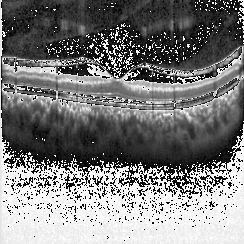

In [ ]:
#transforms on OCT data
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    # ImageNet Normalization
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
    ])

random_state = 6
num_of_classes = 4

# update batch_size: 32, 64, 128
oct_data = OCTDataModule(root_dir=root_dir, transform=transform, batch_size=batch_size, 
                         frac_train_images=frac_train_images, random_state=random_state)
oct_data.setup()

ds_train = oct_data.oct_train
tvf.to_pil_image(ds_train[6][0][0])

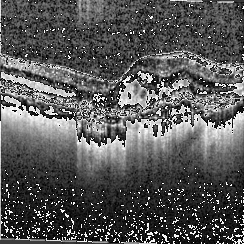

In [ ]:
ds_test = oct_data.oct_test
tvf.to_pil_image(ds_test[6][0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


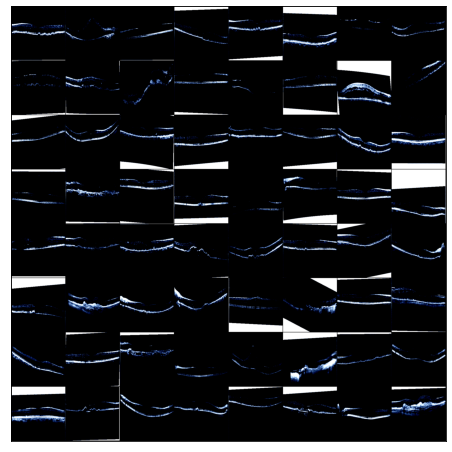

In [ ]:
train_dl = oct_data.train_dataloader()
batch = next(iter(train_dl))[0]
def show_images(images, nmax=32):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(torchvision.utils.make_grid(images, nrow=8).permute(1, 2, 0))
show_images(batch)

## Fine-tuning & Classifier

In [ ]:
# unfreeze params post warm-up.  Can be used with any model.
class UnFreezeCallback(Callback): 
    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch == 10:
            pl_module.embeddings.unfreeze()

In [ ]:
# model
# TODO: add attention map implementation.
# TODO: add label to images uplaoded.
# https://captum.ai/tutorials/Resnet_TorchVision_Interpret

class OCTModel(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        hparams = Namespace(**hparams) if isinstance(hparams, dict) else hparams
        self.hparams = hparams

        # load simCLR pre-trained on imagenet for feature extraction  
        base_model = SimCLR.load_from_checkpoint(hparams.embeddings_path, 
                                                 strict=False)     
        # Set some params
        self.learning_rate = hparams.learning_rate   
        self.tune = hparams.tune

        num_target_classes = hparams.n_classes
        self.embeddings = base_model
        
        #freeze
        if hparams.freeze_base:
            self.embeddings.eval()  

        # Use the pretrained simclr model representations to classify oct. 
        self.classifier = nn.Sequential(
            nn.Linear(self.embeddings.encoder.fc.in_features, 
                      self.embeddings.encoder.fc.in_features),
            nn.ReLU(),
            nn.Linear(self.embeddings.encoder.fc.in_features, 
                      num_target_classes if num_target_classes > 2 else 1),
        )
        
        # Create loss function
        self.loss_fn = torch.nn.CrossEntropyLoss()
    
    def configure_optimizers(self):
        # https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.OneCycleLR
        # optimizers: Adagrad, SGD, Adam, LBFGS, RMSProp, Adamax
        # update
        optimizer = torch.optim.Adagrad(self.parameters(), lr=self.learning_rate,) 
        lr_scheduler = {'scheduler': torch.optim.lr_scheduler.OneCycleLR(
                                        optimizer,
                                        max_lr=self.learning_rate,
                                        steps_per_epoch=int(hparams.steps_per_epoch),
                                        epochs=self.hparams.max_epochs,
                                        anneal_strategy="linear",
                                        final_div_factor = 30,
                                        cycle_momentum=False
                                    ),
                        'name': 'learning_rate',
                        'interval':'step',
                        'frequency': 1}
        return [optimizer], [lr_scheduler]
         
    def forward(self, input_data):
        representations = self.embeddings(input_data)
        preds = self.classifier(representations)
        return preds
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        predictions = self.forward(x)
        loss = self.loss_fn(predictions, y)
        # if not self.tune:
        #   img = x[0]
        #   self.logger.experiment.log_image(img, name="label :{}".format('train_input_image'))
        self.log('train_loss', loss)
        return {'loss': loss}
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        predictions = self.forward(x)
        loss = self.loss_fn(predictions, y)
        # if not self.tune:
        #   img = x[0]
        #   self.logger.experiment.log_image(img, name="label :{}".format('val_input_image'))
        self.log('val_loss', loss)

### Finding best Learning rate parameter for initialization

In [ ]:
# simCLR weight path
weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
hparams = Namespace(
    learning_rate=1e-3,
    freeze_base=True,
    tune=True,
    max_epochs=15,
    steps_per_epoch = len(oct_data.train_dataloader()),
    n_classes=num_of_classes,
    embeddings_path=weight_path,
    batch_size=batch_size,
    optimizer=optimizer
)

#init model
model = OCTModel(hparams)

#tune
trainer = pl.Trainer(gpus=1)
lr_finder = trainer.tuner.lr_find(model,datamodule=oct_data)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | embeddings | SimCLR           | 30.0 M
1 | classifier | Sequential       | 4.2 M 
2 | loss_fn    | CrossEntropyLoss | 0     
------------------------------------------------
34.2 M    Trainable params
0         Non-trainable params
34.2 M    Total params
136.897   Total estimated model params size (MB)


LR finder stopped early due to diverging loss.
Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


suggested learning rate:  0.003311311214825908


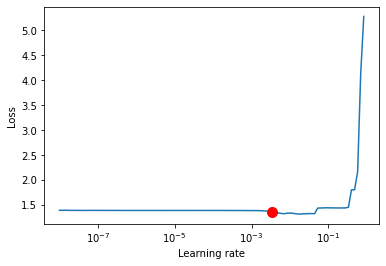

In [ ]:
# Inspect results
lr_finder.plot(show=False, suggest=True)
suggested_lr = lr_finder.suggestion()
print('suggested learning rate: ', suggested_lr)


### Running Classifier model with best initialization parameters

In [ ]:
# Overwrite lr and create new model
weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
hparams = Namespace(
    learning_rate=suggested_lr,
    freeze_base=True,
    tune=False,
    max_epochs=15,
    steps_per_epoch = len(oct_data.train_dataloader()),
    n_classes=num_of_classes,
    embeddings_path=weight_path,
    batch_size=batch_size,
    optimizer=optimizer
)

model_tuned = OCTModel(hparams)

In [ ]:
#init comet.ml logger
# Abdulwahab - exp 1,2,3
# Diego - 4,5,6
# Faris - 7,8,9

experiment_num = 1
date=datetime.today().strftime('%Y%m%d')
experiment_name=f"OCT_classifier_{int(frac_train_images * 100)}train_{experiment_num}_{date}" 
project_name="ml701-ssl-project"

lr_logger = LearningRateMonitor(logging_interval='step')
comet_logger = CometLogger(
    api_key="oqnsyupYtRnpFlgmW4zBl7XxC",
    workspace="abdusah-mbzuai",
    project_name=project_name,
    experiment_name=experiment_name
)
print(f"{experiment_name} comet.ml project: {project_name}")

# checkpoint callback - log at each epoch
checkpoint_callback=pl.callbacks.ModelCheckpoint(
    dirpath=experiment_name + '_ckp',
    monitor='val_loss',
    filename='{epoch}-{train_loss:.2f}-{val_loss:.2f}'    
)

# Define the trainer for our classifier and fit OCT data
trainer = pl.Trainer(max_epochs=hparams.max_epochs,
                     progress_bar_refresh_rate=20,
                     gpus=1,
                     logger=comet_logger,
                     callbacks=[checkpoint_callback, UnFreezeCallback(), lr_logger])
trainer.fit(model_tuned, datamodule=oct_data)

#save checkpoint with weights
checkpoint_file="octmodel.ckpt"
torch.save(model_tuned.state_dict(), 'octmodel')
trainer.save_checkpoint(checkpoint_file)

# save model to comet
# comet_logger.experiment.log_asset(checkpoint_file, step="classifier_training")
comet_logger.experiment.log_model(experiment_name, './octmodel')
comet_logger.experiment.log_model(experiment_name, './octmodel.ckpt')

CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


OCT_classifier_60train_1_20210307 comet.ml project: ml701-ssl-project


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/abdusah-mbzuai/ml701-ssl-project/7e65eb588fe5449fbe031eff211f5245


  | Name       | Type             | Params
------------------------------------------------
0 | embeddings | SimCLR           | 30.0 M
1 | classifier | Sequential       | 4.2 M 
2 | loss_fn    | CrossEntropyLoss | 0     
------------------------------------------------
34.2 M    Trainable params
0         Non-trainable params
34.2 M    Total params
136.897   Total estimated model params size (MB)


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/abdusah-mbzuai/ml701-ssl-project/7e65eb588fe5449fbe031eff211f5245
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [53]       : (0.00025515438755974174, 1.3881385326385498)
COMET INFO:     train_loss [10] : (0.00017395307077094913, 0.21286050975322723)
COMET INFO:     val_loss [15]   : (0.10340938717126846, 2.782442092895508)
COMET INFO:   Others:
COMET INFO:     Name : OCT_classifier_60train_1_20210307
COMET INFO:   Parameters:
COMET INFO:     embeddings_path : https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt
COMET INFO:     freeze_base     : True
COMET INFO:     learning_rate   : 0.003311311214825908
COMET INFO:     max_epochs      : 15
COMET INFO:     n_classes       : 4
COMET I

COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/abdusah-mbzuai/ml701-ssl-project/7e65eb588fe5449fbe031eff211f5245



{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=48728b4cf69b4c6eb5951a6634f48bae&experimentKey=7e65eb588fe5449fbe031eff211f5245',
 'assetId': '48728b4cf69b4c6eb5951a6634f48bae',
 'web': 'https://www.comet.ml/api/asset/download?assetId=48728b4cf69b4c6eb5951a6634f48bae&experimentKey=7e65eb588fe5449fbe031eff211f5245'}

## Evaluation

In [ ]:
def evaluate(data_loader,module):
    with torch.no_grad():
        module.eval() 
        print('set model eval mode')
        true_y, pred_y = [], []
        print('ready')
        for i, _batch in enumerate(data_loader):       
            x, y = _batch    
            y_pred = torch.argmax(module(x), dim=1)
            true_y.extend(y)
            pred_y.extend(y_pred)
            print(f"batch {i} done")
        print('eval done')
        return true_y, pred_y

In [ ]:
# Evaluate predictions on test data
ds_test = oct_data.test_dataloader()
true_y, pred_y = evaluate(ds_test, model_tuned)

In [ ]:
from sklearn.metrics import confusion_matrix
print(idx_to_label)
conf_matrix = confusion_matrix(true_y, pred_y)
print(conf_matrix)
comet_logger.experiment.log_confusion_matrix(
    labels=[idx_to_label[0],idx_to_label[1],idx_to_label[2],idx_to_label[3]],
    matrix=conf_matrix)

{0: 'NORMAL', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}
[[249   0   0   1]
 [  0 238  10   2]
 [  1   2 247   0]
 [  1   4   0 245]]


{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=78ddd722e1964afca4acb6dd0e6c59c3&experimentKey=7e65eb588fe5449fbe031eff211f5245',
 'assetId': '78ddd722e1964afca4acb6dd0e6c59c3',
 'web': 'https://www.comet.ml/api/asset/download?assetId=78ddd722e1964afca4acb6dd0e6c59c3&experimentKey=7e65eb588fe5449fbe031eff211f5245'}

In [ ]:
report = classification_report(true_y, pred_y, digits=3)
print(report)
comet_logger.experiment.log_text(report)

              precision    recall  f1-score   support

           0      0.992     0.996     0.994       250
           1      0.975     0.952     0.964       250
           2      0.961     0.988     0.974       250
           3      0.988     0.980     0.984       250

    accuracy                          0.979      1000
   macro avg      0.979     0.979     0.979      1000
weighted avg      0.979     0.979     0.979      1000



{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=439cb6cadf4c4419a5891a223a2b02a7&experimentKey=7e65eb588fe5449fbe031eff211f5245',
 'assetId': '439cb6cadf4c4419a5891a223a2b02a7',
 'web': 'https://www.comet.ml/api/asset/download?assetId=439cb6cadf4c4419a5891a223a2b02a7&experimentKey=7e65eb588fe5449fbe031eff211f5245'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
COMET ERROR: Could not convert image_data into an image; ignored


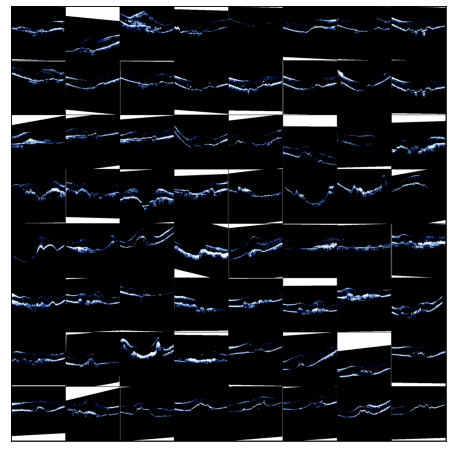

In [ ]:
test_dl = oct_data.test_dataloader()
batch = next(iter(test_dl))[0]
def show_images(images, nmax=32):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(torchvision.utils.make_grid(images, nrow=8).permute(1, 2, 0))
  comet_logger.experiment.log_image(images, name=f"test_sample")
show_images(batch)


In [ ]:
# close experiment - must be called after you use experiment logger
comet_logger.finalize(status='success')

COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/abdusah-mbzuai/ml701-ssl-project/7e65eb588fe5449fbe031eff211f5245
COMET INFO:   Others:
COMET INFO:     Name : OCT_classifier_60train_1_20210307
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix : 1
COMET INFO: -----------------------------------
COMET INFO: Uploading 1 metrics, params and output messages
